<a href="https://github.com/victoresende19" rel="some text">![Foo](https://caminhoslanguages.com/wp-content/uploads/2021/05/earthquakes-brazil-terremotos-brasil.jpg)</a>

<h2 style="text-align:center">Coleta e análise de dados sobre sismos</h2>
<p style="text-align:center;font-size:13px;"></p>
   
<h2 style="text-align:center">Victor Augusto Souza Resende</h2>
<p style="text-align:center;font-size:13px;">Autor</p>

## Sumário

    
- [1. Contexto](#1)<br>
    * [1.2 Observatório sismológico](#12)<br>
    
- [2. Coletando os dados - API](#2) <br>
    * [2.1 Coletando as variáveis necessárias](#21)<br>
    * [2.2 Criando um dataframe com a lista das variáveis coletadas](#22)<br>
    * [2.3 Manipulação dos dados](#23)<br>
        + [2.3.1 Tipo do terremoto](#231)<br>
        + [2.3.2 Variáveis de tempo](#232)<br>
    
- [3. Análise exploratória](#3) <br>
    * [3.1 Magnitude](#31)<br>
    * [3.2 Local](#32)<br>
    * [3.3 Tipo](#33)<br>
    * [3.4 Significância](#34)<br>
    * [3.5 Profundidade](#35)<br>
    * [3.5 Mapas-mundí](#36)<br>
    
- [4. Modelagem](#4) <br>
    * [4.1 Separaçao em treino e teste](#41)<br>
    * [4.2 Normalização dos dados](#42)<br>
    * [4.3 Random forest](#43)<br>
        + [4.3.1 GridSearchCV](#431)<br>
        + [4.3.2 Visualização das árvores](#432)<br>

- [5. Banco de dados (Não utilizado)](#5)<br>
    * [5.1 Conexão SQlite](#51)<br>
        + [5.1.2 Acessando dados SQLite](#512)<br>

In [1]:
!pip install plotly
!pip install sqlalchemy

In [2]:
import pandas as pd
import seaborn as sns

import urllib.request
import json

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

import sqlalchemy               #Acesso ao BD
from sqlalchemy import create_engine

# 1 - Contexto <a id="1"></a>

Com o passar dos anos e o avanço da tecnologia, houve a criação e implementação de sensores em locais com risco de desastres naturais para a verificação de riscos e coleta dos dados. Dessa forma, uma vasta quantidade de dados é gerada diariamente, principalmente quando há situações de tremores, seja em razão de terremotos, erupções, ou até mesmo de ações humanas como acontece em alguns tipos de explosões. 

Portanto, a criação de um observatório sobre tremores e a predição da magnitude de determinada vibração terrestre, dado a longitude e profundidade do tremor, torna-se interessante para o monitoramento de tais fenômenos.

## 1.2 - Observatório sismológico <a id="12"></a>

Este projeto visa a criação de uma solução arquitetada de ponta a ponta, desde a coleta dos dados até a implementação da visualização e modelo de predição interativo com o usuário atráves do Streamlit. 

Por meio do histórico dos dados gerados até então, será possível visualizar as regiões onde tremores são mais comuns, as magnitudes mais altas registradas até então, e diversos outros fatores como, por exemplo, encontrar os tipos de terremotos que mais ocorreram na data especificada.

# 2 - Coletando os dados - API <a id="2"></a>

In [3]:
startTime = '2021-12-15'
endTime = '2022-06-01'
magnitude_desejada = str(2)

url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime={0}&endtime={1}&minmagnitude={2}&limit=20000'.format(startTime, endTime, magnitude_desejada)
response = urllib.request.urlopen(url).read()
data = json.loads(response.decode('utf-8'))

## 2.1 - Coletando as variáveis necessárias <a id="21"></a>

In [4]:
magnitude = []

for mag in data['features']:
    magnitude.append(mag['properties']['mag'])

In [5]:
latitude = []

for lat in data['features']:
    latitude.append(lat['geometry']['coordinates'][1])

longitude = []

for lon in data['features']:
    longitude.append(lon['geometry']['coordinates'][0])
    
profundidade = []

for prof in data['features']:
    profundidade.append(prof['geometry']['coordinates'][2])

In [6]:
timestamp = []

for time in data['features']:
    timestamp.append(time['properties']['time'])

In [7]:
tipoTerremoto = []

for tipo in data['features']:
    tipoTerremoto.append(tipo['properties']['type'])


In [8]:
significancia = []

for sig in data['features']:
    significancia.append(sig['properties']['sig'])

In [9]:
local = []

for loc in data['features']:
    local.append(loc['properties']['place'])

## 2.2 - Criando um dataframe com a lista das variáveis coletadas <a id="22"></a>

In [10]:
dicionario_geral = {'Local': local, 'Magnitude': magnitude, 'Tipo': tipoTerremoto,
                    'Significancia': significancia, 'Profundidade': profundidade,
                    'Latitude': latitude, 'Longitude': longitude, 'Timestamp': timestamp}
df = pd.DataFrame.from_dict(dicionario_geral)
df.tail()

,Local,Magnitude,Tipo,Significancia,Profundidade,Latitude,Longitude,Timestamp
19368,"Izu Islands, Japan region",4.90,earthquake,369,10.00,31.0028,142.2508,1639528858583
19369,"8km WNW of Cobb, CA",2.61,earthquake,105,2.44,38.8365,-122.8125,1639528538570
19370,"47 km SW of Nanwalek, Alaska",2.00,earthquake,62,63.50,59.0345,-152.4782,1639528474794
19371,"2km SE of Orange, CA",2.34,earthquake,139,5.03,33.7920,-117.8225,1639527523360
19372,"Izu Islands, Japan region",4.30,earthquake,284,10.00,31.4056,142.1497,1639526432317


## 2.3 - Manipulação dos dados <a id="23"></a>

In [11]:
df.dtypes

Local             object
Magnitude        float64
Tipo              object
Significancia      int64
Profundidade     float64
Latitude         float64
Longitude        float64
Timestamp          int64
dtype: object

### 2.3.1 - Tipo do terremoto <a id="231"></a>

Essa abordagem teve como objetivo a melhor visualização do usuário quando o código for implementado na web via biblioteca streamlit

In [12]:
#Variável Tipo
mapping_tipo = {"Tipo": {'earthquake': 'Terremoto', 'explosion': 'Explosão', 'nuclear explosion':'Explosão Nuclear', 'rock burst': 'Explosão de mina', 'quarry blast': 'Explosão de mina'}}
df = df.replace(mapping_tipo)

#Verificando alterações
df.tail()

,Local,Magnitude,Tipo,Significancia,Profundidade,Latitude,Longitude,Timestamp
19368,"Izu Islands, Japan region",4.90,Terremoto,369,10.00,31.0028,142.2508,1639528858583
19369,"8km WNW of Cobb, CA",2.61,Terremoto,105,2.44,38.8365,-122.8125,1639528538570
19370,"47 km SW of Nanwalek, Alaska",2.00,Terremoto,62,63.50,59.0345,-152.4782,1639528474794
19371,"2km SE of Orange, CA",2.34,Terremoto,139,5.03,33.7920,-117.8225,1639527523360
19372,"Izu Islands, Japan region",4.30,Terremoto,284,10.00,31.4056,142.1497,1639526432317


### 2.3.2 - Variáveis de tempo <a id="232"></a>

Ajustando a variável timestamp que está na unidade de millisegundos, criando uma coluna com apenas o ano do tremor (Que será utilizada nos gráficos) e reordenando o dataframe da data mais antiga para a mais atual escolhida pelo usuário no início do estudo.

In [13]:
#Ajustando timestamp
df.Timestamp = pd.to_datetime(df.Timestamp, unit='ms')

#Crianção da variável Ano
df['Year'] = pd.to_datetime(df.Timestamp).dt.year

#Reordenando o dataframe
df = df.sort_values(by=['Timestamp'], ascending=True).reset_index()
df.drop(columns = ['index'], inplace = True)

#Verificando alterações
df.head()

,Local,Magnitude,Tipo,Significancia,Profundidade,Latitude,Longitude,Timestamp,Year
0,"Izu Islands, Japan region",4.30,Terremoto,284,10.00,31.4056,142.1497,2021-12-15 00:00:32.317,2021
1,"2km SE of Orange, CA",2.34,Terremoto,139,5.03,33.7920,-117.8225,2021-12-15 00:18:43.360,2021
2,"47 km SW of Nanwalek, Alaska",2.00,Terremoto,62,63.50,59.0345,-152.4782,2021-12-15 00:34:34.794,2021
3,"8km WNW of Cobb, CA",2.61,Terremoto,105,2.44,38.8365,-122.8125,2021-12-15 00:35:38.570,2021
4,"Izu Islands, Japan region",4.90,Terremoto,369,10.00,31.0028,142.2508,2021-12-15 00:40:58.583,2021


# 3 - Análise exploratória <a id="3"></a>

In [14]:
df.describe()

,Magnitude,Significancia,Profundidade,Latitude,Longitude,Year
count,19373.000000,19373.000000,19373.000000,19373.000000,19373.000000,19373.000000
mean,3.280828,185.266402,47.700548,23.410546,-62.155573,2021.896402
std,1.081735,120.733936,92.861159,29.005798,116.696840,0.304746
min,2.000000,62.000000,-3.450000,-69.773900,-179.999700,2021.000000
25%,2.260000,79.000000,10.000000,12.346800,-155.422333,2022.000000
50%,2.900000,129.000000,13.890000,26.814600,-105.365200,2022.000000
75%,4.400000,298.000000,36.029999,47.090800,0.123300,2022.000000
max,7.300000,2384.000000,653.870000,86.647700,180.000000,2022.000000


## 3.1 - Magnitude <a id="31"></a>

In [15]:
df.Magnitude.describe()

count    19373.000000
mean         3.280828
std          1.081735
min          2.000000
25%          2.260000
50%          2.900000
75%          4.400000
max          7.300000
Name: Magnitude, dtype: float64

Text(0, 0.5, 'Frequência')

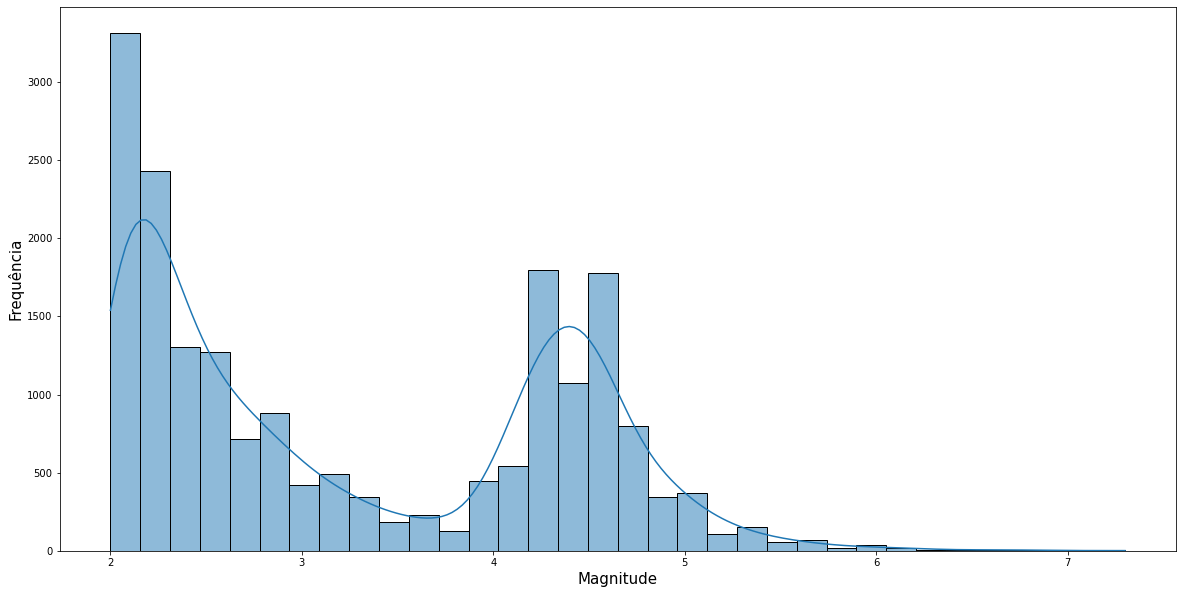

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(20,10))
hist = sns.histplot(data=df, x="Magnitude",  kde=True)

ax.hist
ax.set_xlabel('Magnitude', size = 15)
ax.set_ylabel('Frequência', size = 15)

## 3.2 - Local <a id="32"></a>

In [17]:
df.Local.describe()

count                             19197
unique                            11310
top       South Sandwich Islands region
freq                                345
Name: Local, dtype: object

In [18]:
df.Local.value_counts()

South Sandwich Islands region            345
Rat Islands, Aleutian Islands, Alaska    246
Kermadec Islands region                  196
south of the Fiji Islands                181
Fiji region                              118
                                        ... 
212 km SE of Sarangani, Philippines        1
28 km SW of Karluk, Alaska                 1
6 km NW of Albardón, Argentina             1
202 km SSE of Hirara, Japan                1
20km NNE of Ridgecrest, CA                 1
Name: Local, Length: 11310, dtype: int64

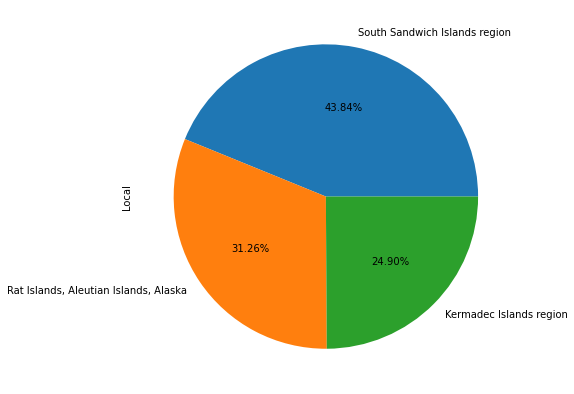

In [19]:
fig, ax = plt.subplots(figsize=(20,7))
df.Local.value_counts().iloc[:3].plot(x=None,y=None, kind='pie', ax=ax, autopct='%1.2f%%')
#ax.set_title("Porcentagem do Sexo dos hospedes")
plt.show()

Text(0, 0.5, 'Frequência')

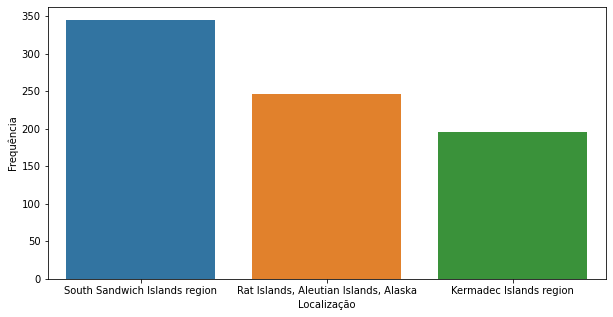

In [20]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
bar = sns.countplot(x ='Local', data = df, order=df.Local.value_counts().iloc[:3].index)

ax.bar
ax.set_xlabel('Localização', size = 10)
ax.set_ylabel('Frequência', size = 10)

## 3.3 - Tipo <a id="33"></a>

In [21]:
df.Tipo.describe()

count         19373
unique            6
top       Terremoto
freq          19193
Name: Tipo, dtype: object

In [22]:
df.Tipo.value_counts()

Terremoto            19193
mining explosion       102
Explosão                39
ice quake               23
Explosão de mina        15
volcanic eruption        1
Name: Tipo, dtype: int64

Text(0, 0.5, 'Frequência')

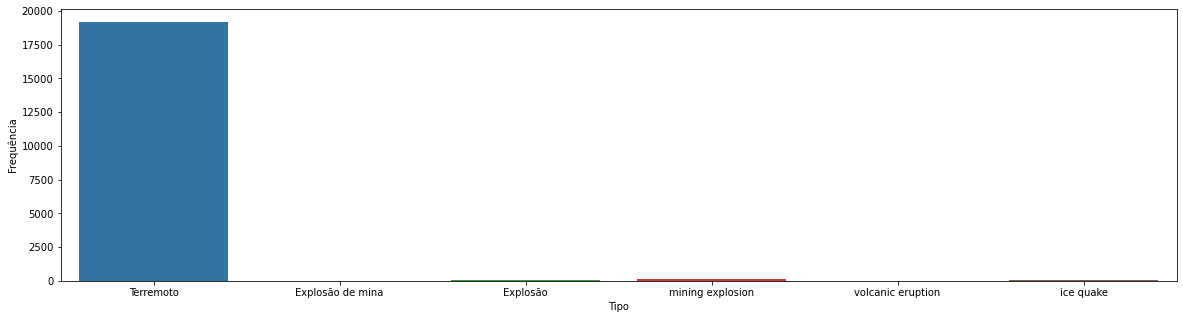

In [23]:
fig, ax = plt.subplots(1, 1,figsize=(20,5))
bar = sns.countplot(x ='Tipo', data = df)

ax.bar
ax.set_xlabel('Tipo', size = 10)
ax.set_ylabel('Frequência', size = 10)

Text(0, 0.5, 'Frequência')

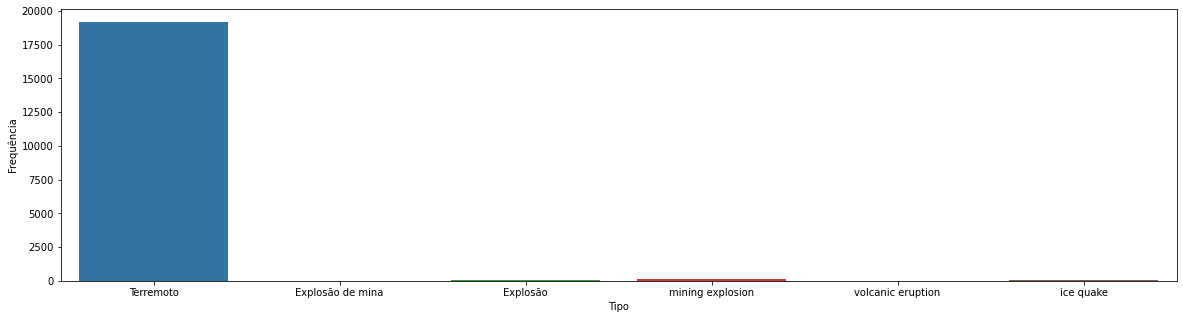

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(20,5))
bar = sns.countplot(x ='Tipo', data = df[df.Tipo != 'earthquake'])

ax.bar
ax.set_xlabel('Tipo', size = 10)
ax.set_ylabel('Frequência', size = 10)

In [25]:
df[df.Tipo == 'other event'].Magnitude.max()

nan

## 3.4 - Signficiância <a id="34"></a>

In [26]:
df.Significancia.describe()

count    19373.000000
mean       185.266402
std        120.733936
min         62.000000
25%         79.000000
50%        129.000000
75%        298.000000
max       2384.000000
Name: Significancia, dtype: float64

Text(0, 0.5, 'Frequência')

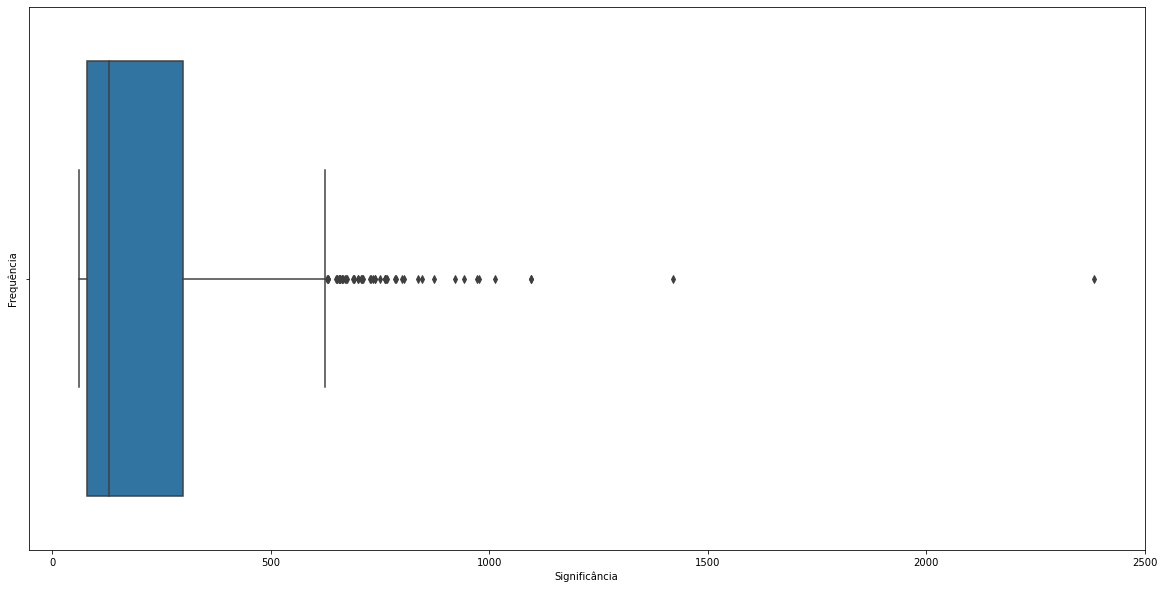

In [27]:
fig, ax = plt.subplots(1, 1,figsize=(20,10))
hist = sns.boxplot(data=df, x="Significancia")

ax.hist
ax.set_xlabel('Significância', size = 10)
ax.set_ylabel('Frequência', size = 10)

In [28]:
valor = df['Significancia']
Q1= valor.quantile(.25)
Q2 = valor.quantile(.50)
Q3 = valor.quantile(.75)

IIQ = (Q3 - Q1).round(2)

LIC = Q1 - 1.5 * IIQ

LSC = Q3 + 1.5 * IIQ

print(f'Q1:{Q1}\nQ3:{Q3}\nMediana:{Q2}\nLimite Superior:{LSC}\nLimite Inferior:{LSC}')

Q1:79.0
Q3:298.0
Mediana:129.0
Limite Superior:626.5
Limite Inferior:626.5


## 3.5 - Profundidade <a id="35"></a>

In [29]:
df.Profundidade.describe()

count    19373.000000
mean        47.700548
std         92.861159
min         -3.450000
25%         10.000000
50%         13.890000
75%         36.029999
max        653.870000
Name: Profundidade, dtype: float64

Text(0, 0.5, 'Frequência')

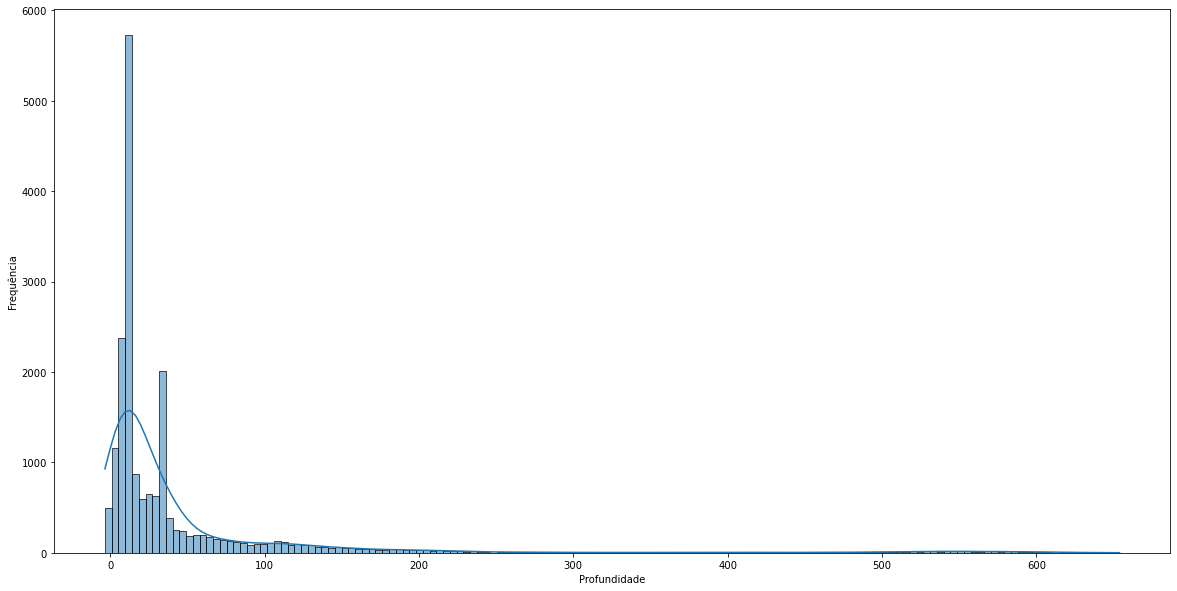

In [30]:
fig, ax = plt.subplots(1, 1,figsize=(20,10))
hist = sns.histplot(data=df, x="Profundidade",  kde=True, bins = 150)

ax.hist
ax.set_xlabel('Profundidade', size = 10)
ax.set_ylabel('Frequência', size = 10)

In [31]:
df.Profundidade.describe()

count    19373.000000
mean        47.700548
std         92.861159
min         -3.450000
25%         10.000000
50%         13.890000
75%         36.029999
max        653.870000
Name: Profundidade, dtype: float64

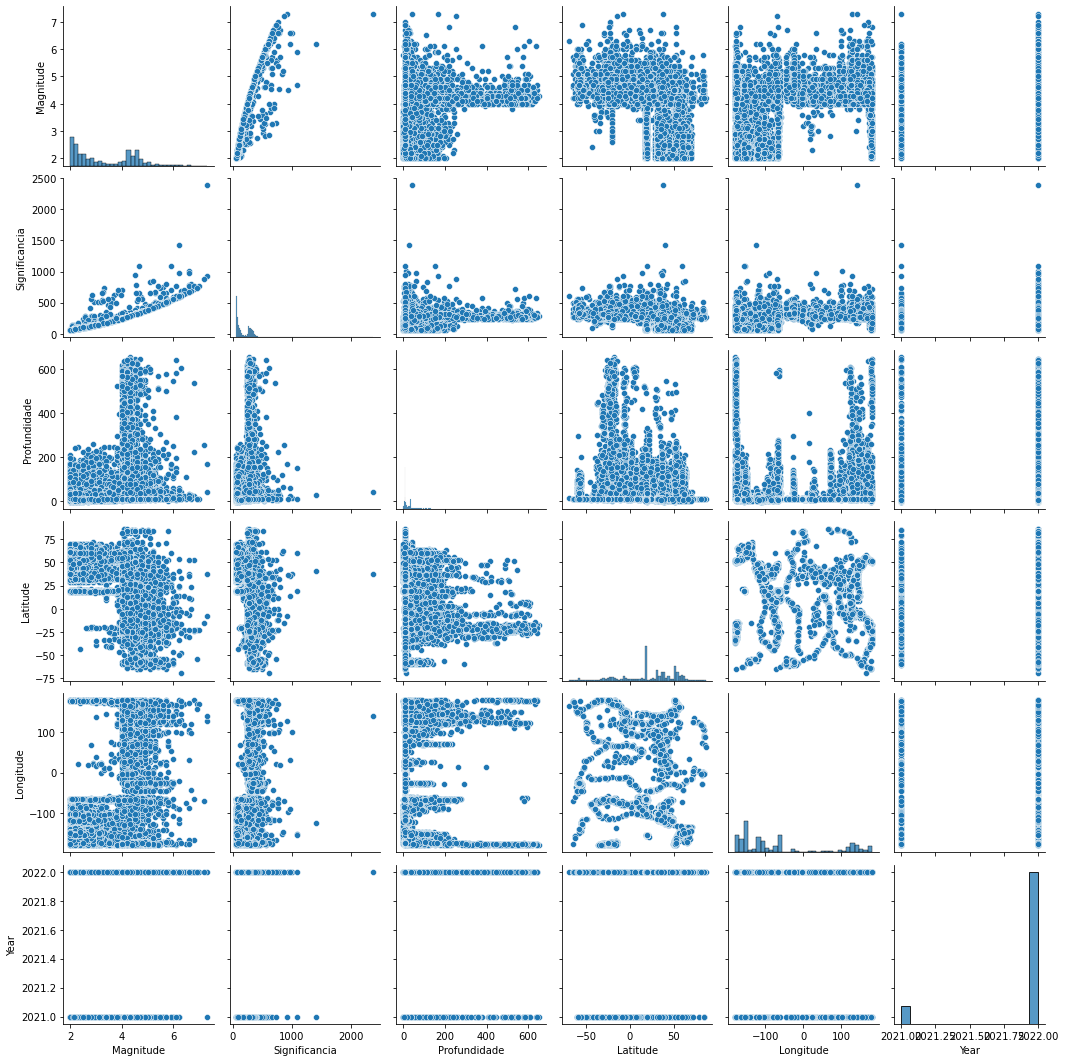

In [32]:
sns.pairplot(df)

## 3.6 - Mapas-mundí <a id="36"></a>

In [33]:
#!pip install geopandas
#!pip install Basemap

# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt


# m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

# longitudes = df["Longitude"].tolist()
# latitudes = df["Latitude"].tolist()

# x,y = m(longitudes,latitudes)

# fig = plt.figure(figsize=(12,10))
# plt.title(f"Terremotos - {df.Year.min()} a {df.Year.max()}")
# m.plot(x, y, "o", markersize = 4, color = 'red')
# m.drawcoastlines()
# m.fillcontinents(color='pink',lake_color='aqua')
# m.drawmapboundary()
# m.drawcountries()
# plt.show()

In [34]:
# figMapaMundi = px.scatter_geo(data_frame=df, lat="Latitude", lon="Longitude", color="Magnitude", size=df.Magnitude**10, size_max=60, 
#                               color_continuous_scale=['#04290d', 'yellow', 'red'], width=900, height=600)
# figMapaMundi.layout.geo.projection = {'rotation': {'lon': 200}, 'type': 'natural earth'} #Ajustando rotacao do globo
# figMapaMundi.update_geos(showcountries=True) #Fazendo com que as fronteiras aparecam

# 4 - Modelagem <a id="4"></a>

<AxesSubplot:>

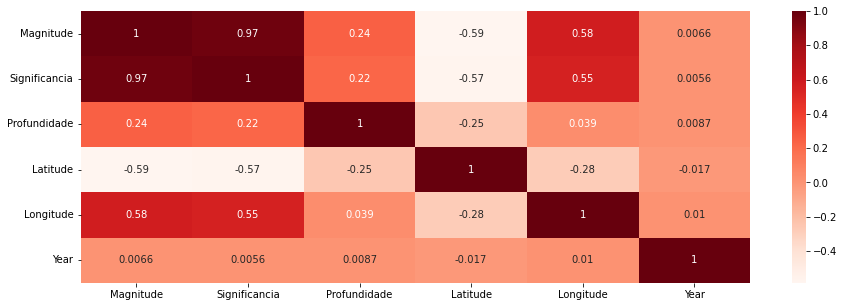

In [35]:
figure(figsize=(15,5))
sns.heatmap(df.corr(), annot = True, cmap="Reds")

In [36]:
cols =  ['Longitude', 'Profundidade']
X = df.loc[:, cols].values
y = df.loc[:, 'Magnitude'].values

## 4.1 - Separaçao em treino e teste <a id="41"></a>

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## 4.2 - Normalização dos dados <a id="42"></a>

In [38]:
#Normalização dos dados
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_stand_train = ss.fit_transform(X_train)
X_stand_test = ss.transform(X_test)

## 4.3 - Random forest <a id="43"></a>

In [39]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()

#padronizado zscore
regressor.fit(X_stand_train, y_train)
y_pred = regressor.predict(X_stand_test)

#regressor.fit(X_train, y_train)
#y_pred = regressor.predict(X_test)

#R2
score_stand_ran = regressor.score(X_stand_test, y_test) #zscore
#score_stand_ran = regressor.score(X_test, y_test)

#MSE
mse = mean_squared_error(y_test, y_pred)

#Métricas
print(f'R2 Random Forest Regressor: {score_stand_ran:.2f}')
print(f'MSE: {mse:.2f}')

#Testando previsoes (Longitude e Profundidade)
new_array = np.array([-47.998134488899034, 53]).reshape(-1, 2)
print(f'Terremoto: {regressor.predict(new_array)[0]:.2f}')

R2 Random Forest Regressor: 0.76
MSE: 0.28
Terremoto: 4.48


### 4.3.1 - GridSearchCV<a id="431"></a>

In [40]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
parameters = [{
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}]

#grid_search = GridSearchCV(estimator = regressor, param_grid = parameters, scoring = 'r2', cv = 10, n_jobs = -1)

#grid_search = grid_search.fit(X_stand_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print(f'Melhor acurácia: {best_accuracy}\nMelhores parâmetros: {best_parameters}')

In [41]:
len(regressor.estimators_)

100

### 4.3.2 - Visualização das árvores <a id="432"></a>

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

n_arvore = 0

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,15), dpi=800)
plot_tree(regressor.estimators_[n_arvore], 
          feature_names=['Profundidade', 'Longitude'],
          class_names=['Magnitude'], 
          filled=True, impurity=True, proportion = True, fontsize = 5,
          rounded=False, max_depth = 3)
fig.savefig(f'Modelo-Arvore-LongProf-Numero-{n_arvore}.png')

In [43]:
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (40,25), dpi=900)
# for i in range(0, 5):
#     tree.plot_tree(
#         regressor.estimators_[i], 
#         feature_names=['Profundidade', 'Longitude'],
#         class_names=['Magnitude'], 
#         filled=True, impurity=True, proportion = True, fontsize = 5,
#         rounded=False, max_depth = 3, ax = axes[i])

#     axes[index].set_title('Estimator: ' + str(i), fontsize = 20)
# fig.savefig('Modelo-Arvores-0-4.png')

# 5 - Banco de dados (não utilizado) <a id="5"></a>

## 5.1 - Conexão SQlite <a id="51"></a>

In [44]:
# db = create_engine('sqlite:///earthquakes-final.sqlite', echo = False)
# conn = db.connect()

In [45]:
# schema_earthquakes = '''
# CREATE TABLE earthquakes(
#     Local                 TEXT,
#     Magnitude             REAL,
#     Tipo                  TEXT,
#     Significancia         Integer,
#     Profundidade          REAL,
#     Latitude              REAL,
#     Longitude             REAL,
#     Timestamp             TEXT,
#     Year                  Integer
# )
# '''

In [46]:
# df.to_sql('earthquakes', con = conn, if_exists = 'append', index = False)

In [47]:
# db = create_engine('sqlite:///earthquakes-final.sqlite', echo = False)
# conn = db.connect()

In [48]:
# df = pd.read_sql_query( '''SELECT * FROM earthquakes''', conn )
# df.head()
# conn.close()

In [49]:
# df = df.drop_duplicates(subset=['Local', 'Magnitude', 'Tipo', 'Significancia', 'Profundidade'])

### 5.1.2 - Acessando dados SQLite <a id="512"></a>

In [50]:
#db = create_engine('sqlite:///earthquakes-victor.sqlite', echo = False)
#conn = db.connect()

#df = pd.read_sql_query( '''SELECT * FROM earthquakes''', conn )
#df

In [51]:
#conn.close()